In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as interp
import cmocean
import pyshtools
from pathlib import Path
from cartopy import crs as ccrs
import cartopy.feature as cfeature

Generating GLQ grid ...
Interpolating data onto GLQ grid ...
Performing SH transform ...
Taking the inverse SH transform ...
Plotting ...


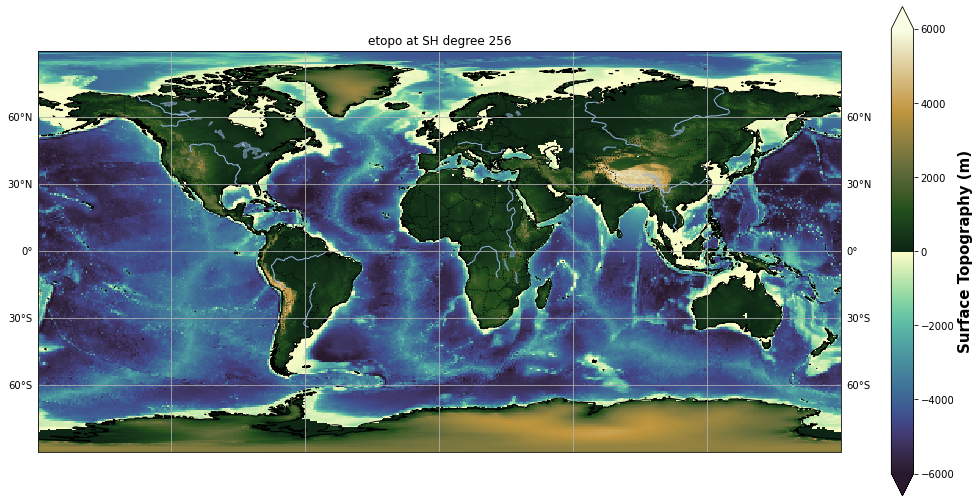

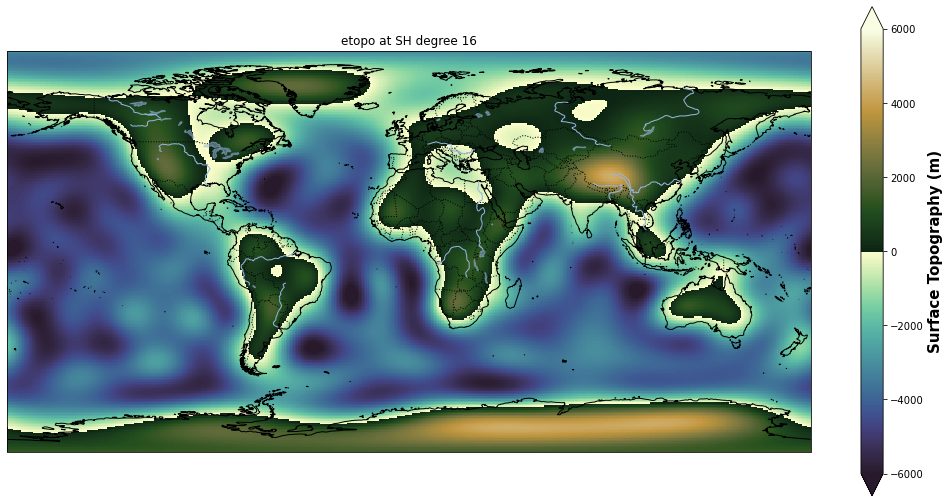

In [29]:
lmax=256 #Our maximum degree used in the SH transform
lreturn=16 #The maximum degree we truncate to for the inverse SH transform

#################### LOAD DATA
mf1 = Path("./etopo_ice_15.npy")
mf2 = Path("./etopo_ice_15.txt")

if mf1.is_file():
    etopo = np.load('etopo_ice_15.npy')

elif mf2.is_file():
    etopo = np.loadtxt('etopo_ice_15.txt') #lon, lat, topography
  
  #numpy .npy binary format example
    np.save('etopo_ice_15.npy',etopo)

else:
    print("Can not find etopo file")

############## Reshape etopo
num1 = np.unique(etopo[:,0]).size
num2 = np.unique(etopo[:,1]).size

lon2 = np.reshape(etopo[:,0],(num1,num2)).T
lat2 = np.reshape(etopo[:,1],(num1,num2)).T
topo2 = np.reshape(etopo[:,2],(num1,num2)).T

topo_interp = interp.interp2d(lon2[1,:],lat2[:,1],topo2)

############## Construct gauss legendre grid
print("Generating GLQ grid ...")
latglq, longlq = pyshtools.expand.GLQGridCoord(lmax) #too stay consistent with matlab
longlq2,latglq2 = np.meshgrid(longlq,np.sort(latglq)) #latglq should be in assending order

############## Interplate data onto grid
print("Interpolating data onto GLQ grid ...")
topoglq2 = topo_interp(longlq,latglq)

############## Spherical harmonic transform
print("Performing SH transform ...")
zero, w = pyshtools.expand.SHGLQ(lmax)
cilm = pyshtools.expand.SHExpandGLQC(topoglq2,w,zero,norm=1,csphase=1,lmax_calc=lmax)

############## Inverse Spherical harmonic transform
print("Taking the inverse SH transform ...")
gridglq = pyshtools.expand.MakeGridGLQC(cilm,zero,lmax=lmax,norm=1,csphase=1,lmax_calc=lreturn)

############## Plot results
print("Plotting ...")

##Initial topography on GLQ grid
f1 = plt.figure(figsize=(18,12))
# add a subplot
ax1 = f1.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# set the extent (you will need to change this for your problem set)
# ax1.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())


def add_features(ax):
    
    # add coastal features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    return ax

ax1 = add_features(ax1)

# add gridlines
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# m1 = Basemap(projection='robin',lon_0=0,resolution='c')
# m1.drawcoastlines()
# m1.drawparallels(np.arange(-90.,120.,30.), labels=[True,False,False,False])
# m1.drawmeridians(np.arange(0.,360.,60.), labels=[False,False,False,True])

t1 = ax1.pcolormesh(longlq2,latglq2,topoglq2,cmap = cmocean.cm.topo, vmin=-6000, vmax=6000)

cb = f1.colorbar(t1, ax=ax1, shrink=0.75, extend='both')
cb.set_label(label='Surface Topography (m)',size=15,weight='bold')
plt.title('etopo at SH degree ' + str(lmax))


#Final topography on GLQ grid after truncation
f2 = plt.figure(figsize=(18,12))
ax2 = f2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax2 = add_features(ax2)



#To deal with complex numbers in gridglq
tmp = np.sign(gridglq).real*np.abs(gridglq)

t2 = ax2.pcolormesh(longlq2,latglq2,tmp,cmap = cmocean.cm.topo, vmin=-6000, vmax=6000)

cb2 = f2.colorbar(t2, ax=ax2, shrink=0.75, extend='both')
cb2.set_label(label='Surface Topography (m)',size=15,weight='bold')
plt.title('etopo at SH degree ' + str(lreturn))

plt.show()
